Importing Libraries

In [2]:
# Importing Required Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

Dataset Loading

In [3]:
# Load the dataset
df = pd.read_csv("synthetic_sensor_data.csv")  

# Step 1: Check missing values in Dataset
print(df.isnull().sum())

Timestamp         0
Temperature       0
Anomaly           0
Location       3296
dtype: int64


Data Handling

In [4]:
# Get index of NaN values
nan_indices = df[df['Location'].isna()].index

# Split indices into two halves
half = len(nan_indices) // 2

# Fill first half with 'A', second half with 'B'
df.loc[nan_indices[:half], 'Location'] = 'SensorA'
df.loc[nan_indices[half:], 'Location'] = 'SensorB'

print(df)

                Timestamp  Temperature  Anomaly Location
0     2024-06-01 19:50:28    24.476332        0  SensorB
1     2024-06-01 19:50:28    18.253966        0  SensorA
2     2024-06-01 19:50:28    14.953520        0  SensorB
3     2024-06-01 19:50:28    17.667181        0  SensorA
4     2024-06-01 19:50:28    17.079826        0  SensorA
...                   ...          ...      ...      ...
9995  2024-06-01 19:50:29    26.460733        0  SensorA
9996  2024-06-01 19:50:29    22.027875        0  SensorB
9997  2024-06-01 19:50:29    17.917821        0  SensorA
9998  2024-06-01 19:50:29    23.730639        0  SensorB
9999  2024-06-01 19:50:29    25.680470        0  SensorB

[10000 rows x 4 columns]


In [5]:
# Ensuring of No Null Values present
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Timestamp    10000 non-null  object 
 1   Temperature  10000 non-null  float64
 2   Anomaly      10000 non-null  int64  
 3   Location     10000 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 312.6+ KB


In [6]:
df.drop('Timestamp', axis=1, inplace=True)  # Since, feature "Timestamp" has same kind of Data, We are neglecting it

In [7]:
from sklearn.preprocessing import LabelEncoder

# Create encoder object
le = LabelEncoder()

# Apply encoding
df['Location_encoded'] = le.fit_transform(df['Location'])

In [8]:
df.head()

,Temperature,Anomaly,Location,Location_encoded
0,24.476332,0,SensorB,1
1,18.253966,0,SensorA,0
2,14.953520,0,SensorB,1
3,17.667181,0,SensorA,0
4,17.079826,0,SensorA,0


In [9]:
# Define X, y and Split Data
# X = features, y = target column ("Anomaly")
X = df[['Temperature', 'Location_encoded']]
y = df["Anomaly"]

In [10]:
X

,Temperature,Location_encoded
0,24.476332,1
1,18.253966,0
2,14.953520,1
3,17.667181,0
4,17.079826,0
...,...,...
9995,26.460733,0
9996,22.027875,1
9997,17.917821,0
9998,23.730639,1


In [11]:
y

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: Anomaly, Length: 10000, dtype: int64

Train-Test-Split

In [12]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47, stratify=y)

# Apply SMOTE only on training data
sm = SMOTE(random_state=47)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

Model Building- on Training Dataset

In [13]:
# Train Random Forest
rf_model = RandomForestClassifier(random_state=47)
rf_model.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Results:")
print("Accuracy:", rf_model.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_rf))


Random Forest Results:
Accuracy: 0.9995
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1954
           1       0.98      1.00      0.99        46

    accuracy                           1.00      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
 [[1953    1]
 [   0   46]]
ROC-AUC Score: 0.9997441146366428


Evaluation Metrics using Test Data

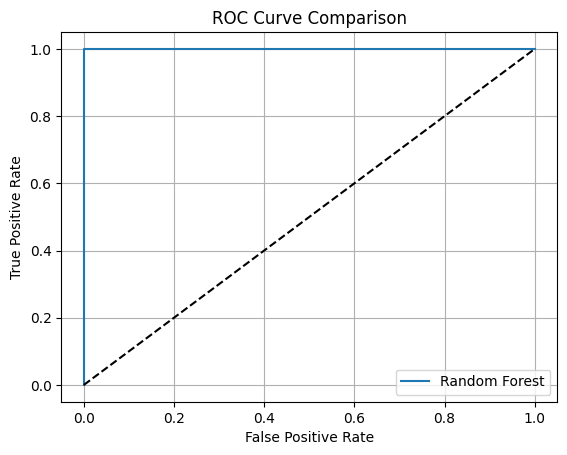

In [14]:
# ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Random Forest')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

In [15]:
import joblib

# Save the trained model
joblib.dump(rf_model, "industrial_anomaly_rf_model.pkl")
print("Model saved as 'industrial_anomaly_rf_model.pkl'")

Model saved as 'industrial_anomaly_rf_model.pkl'


In [16]:
# Load the saved model
loaded_model = joblib.load("industrial_anomaly_rf_model.pkl")

# Example usage
sample_prediction = loaded_model.predict(X_test[:5])
print("Predicted values:", sample_prediction)

Predicted values: [0 0 0 0 0]
